In [1]:
import torch
import random
from collections import Counter
from itertools import combinations

from base_funcs import *
from model import *

from matplotlib import pyplot as plt

import numpy as np

In [2]:
def simEpisode_notrain(Init_states, Models, temperature, verbose=0):
    if Init_states is None:

        Init_states = init_game_3card() # [Lstate, Dstate, Ustate]

    public_cards = state2str(Init_states[-1].numpy().sum(axis=0))

    Log = f'Landlord Cards: {public_cards}\n'
    Qs = []

    unavail = ''
    history = torch.zeros((15,4,15))
    lastmove = ['',(0,0)]

    Turn = 0
    Npass = 0 # number of pass applying to rules
    Cpass = 0 # continuous pass
    Condition = 0

    Forcemove = True # whether pass is not allowed

    while True: # game loop
        # get player
        #print(Turn, lastmove)
        player, model = Init_states[Turn%3], Models[Turn%3]
        visible = Init_states[-1]
        # get card count
        card_count = [int(p.sum()) for p in Init_states]
        #print(card_count)
        CC = torch.zeros((4,15))
        CC[0][:min(card_count[0],15)] = 1
        CC[1][:min(card_count[1],15)] = 1
        CC[2][:min(card_count[2],15)] = 1
        #print(CC)

        # get action
        Bigstate = torch.concat([player.unsqueeze(0),str2state(unavail).unsqueeze(0),CC.unsqueeze(0),visible.unsqueeze(0),
                                 history])

        # get all actions
        acts = avail_actions(lastmove[0],lastmove[1],Bigstate[0],Forcemove)

        # generate inputs
        hinput = torch.concat([torch.concat([Bigstate,str2state(a[0]).unsqueeze(0)]).unsqueeze(0) for a in acts])

        # get q values
        output = model(hinput).flatten()
        #print(output)
        if temperature == 0:
            Q = torch.max(output)
            best_act = acts[torch.argmax(output)]
        else:
            # get action using probabilistic approach and temperature
            probabilities = torch.softmax(output / temperature, dim=0)
            distribution = torch.distributions.Categorical(probabilities)
            
            q = distribution.sample()
            best_act = acts[q]
            Q = output[q]
        
        action = best_act

        
        Qs.append(Q.item())
        if Forcemove:
            Forcemove = False

        # conduct a move
        myst = state2str(player.sum(dim=0).numpy())
        cA = Counter(myst)
        cB = Counter(action[0])
        newst = ''.join(list((cA - cB).elements()))
        newunavail = unavail + action[0]
        newhist = torch.roll(history,1,dims=0)
        newhist[0] = str2state(action[0]) # first row is newest, others are moved downward
        
        #newlast = ['',(0,0)]
        play = action[0]
        if action[1][0] == 0:
            play = 'pass'
            Cpass += 1
            if Npass < 1:
                Npass += 1
            else:
                #print('Clear Action')
                newlast = ['',(0,0)]
                Npass = 0
                Forcemove = True
        else:
            newlast = action
            Npass = 0
            Cpass = 0

        #myst, action[0], newst, newunavail, newhist[0], newlast
        Log += f"{Label[Turn % 3]} {str(Turn).zfill(2)}    {myst.zfill(20).replace('0', ' ')} {play.zfill(20).replace('0', ' ')} by {Label[Turn % 3]}    {str(round(Q.item()*100,1)).zfill(5)}%\n"
        if Cpass == 2:
            Log += '\n'
        if verbose:
            print(Label[Turn%3], str(Turn).zfill(2), '   ', myst.zfill(20).replace('0',' '), play.zfill(20).replace('0',' '), 'by', Label[Turn%3], f'{round(Q.item()*100,1)}%')
            if Cpass == 2:
                print('')
        # record
        nextstate = str2state(newst)


        # update
        Init_states[Turn%3] = nextstate
        unavail = newunavail
        history = newhist
        lastmove = newlast
        
        if len(newst) == 0:
            Condition = 1
            break

        Turn += 1

    #if Condition == 1:
    if Turn %3 == 0:
        Log += f'\nLandlord Wins'
    else:
        Log += f'\nFarmers Win'
    if verbose:
        if Turn %3 == 0:
            print(f'\nLandlord Wins')
        else:
            print(f'\nFarmers Win')
    #print(len(BufferStatesActs[0]),len(BufferRewards[0]))
    #quit()
    return Turn, Qs, Log

In [3]:
if torch.get_num_threads() > 1:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)

In [4]:
Label = ['Landlord','Farmer-0','Farmer-1']
N_history = 15 # number of historic moves in model input
N_feature = 5

LM, DM, UM = Network_V3(N_history+N_feature),Network_V3(N_history+N_feature),Network_V3(N_history+N_feature)
v_FM = 'H15-V5.0_0001100000'
v_LM = 'H15-V5.0_0001100000'
LM.load_state_dict(torch.load(f'models/LM_{v_LM}.pt'))
DM.load_state_dict(torch.load(f'models/DM_{v_FM}.pt'))
UM.load_state_dict(torch.load(f'models/UM_{v_FM}.pt'))

print('Init Wt',LM.fc1.weight.data)

Init Wt tensor([[-0.0949,  0.0092,  0.0429,  ..., -0.0831,  0.0101,  0.0641],
        [-0.0156, -0.0090,  0.0370,  ..., -0.0355, -0.0844, -0.1240],
        [ 0.0157,  0.0068,  0.0124,  ..., -0.0659,  0.1480,  0.1753],
        ...,
        [-0.0312,  0.0092, -0.0286,  ...,  0.1006,  0.1828,  0.1761],
        [-0.0456, -0.0644, -0.0801,  ...,  0.3394,  0.1865,  0.2039],
        [-0.0386, -0.0096, -0.0368,  ...,  0.0399, -0.0146, -0.0029]])


In [5]:
Deck = init_game_3card()

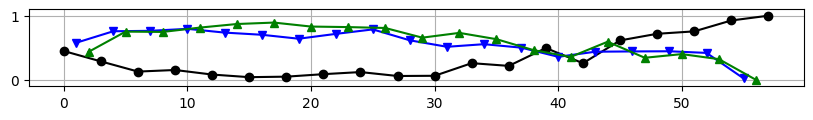

Player Turn |          Current Card |             Action                Win Rate
Landlord Cards: 89A
Landlord 00    33455667789XJQQKA22B               556677 by Landlord    044.9%
Farmer-0 01       345778899XJQKAAAR               778899 by Farmer-0    057.8%
Farmer-1 02       34456689XXJJQKK22                 pass by Farmer-1    043.6%
Landlord 03          33489XJQQKA22B                 pass by Landlord    028.8%

Farmer-0 04             345XJQKAAAR                XJQKA by Farmer-0    075.7%
Farmer-1 05       34456689XXJJQKK22                 pass by Farmer-1    075.2%
Landlord 06          33489XJQQKA22B                 pass by Landlord    012.9%

Farmer-0 07                  345AAR                    5 by Farmer-0    076.4%
Farmer-1 08       34456689XXJJQKK22                    J by Farmer-1    074.7%
Landlord 09          33489XJQQKA22B                    K by Landlord    015.4%
Farmer-0 10                   34AAR                    A by Farmer-0    079.5%
Farmer-1 11        34456689X

In [15]:
Turn = 20
while Turn < 50:
    Turn, Qs, Log = simEpisode_notrain(
    #[str2state('33455788XJJJQKAAA22R'),str2state('3445567799XXJQA22'),str2state('3466678899XQQKKKB')], #v1_029
    None,
    #[i.clone().detach() for i in Deck],
    [LM,DM,UM],0.0,0)
    #break
plt.figure(figsize=(10,1))
plt.plot(range(0,len(Qs),3),Qs[::3],marker='o',color='black')
plt.plot(range(1,len(Qs),3),Qs[1::3],marker='v',color='blue')
plt.plot(range(2,len(Qs),3),Qs[2::3],marker='^',color='green')
plt.ylim(-0.1,1.1)
plt.grid()
plt.show()

print('Player Turn |          Current Card |             Action                Win Rate')
print(Log)